In [1]:
%matplotlib inline
import numpy as np
import ringdown as rd
import arviz as az
from pycbc.types import TimeSeries
import h5py
from scipy.interpolate import interp1d

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

# Plot waveform in time domain

In [3]:
fit = rd.Fit(model='mchi_aligned')
fit.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0603_srate2048_pystan.nc')

In [4]:
h = fit.result.posterior.h_det.stack(samples=('chain', 'draw'))
lp = fit.result.sample_stats.lp.stack(samples=('chain','draw'))
imaxlp = np.argmax(lp.values)
hmax = h.values[0,:,imaxlp]

In [5]:
hpycbc = TimeSeries(hmax,delta_t=1/2048)

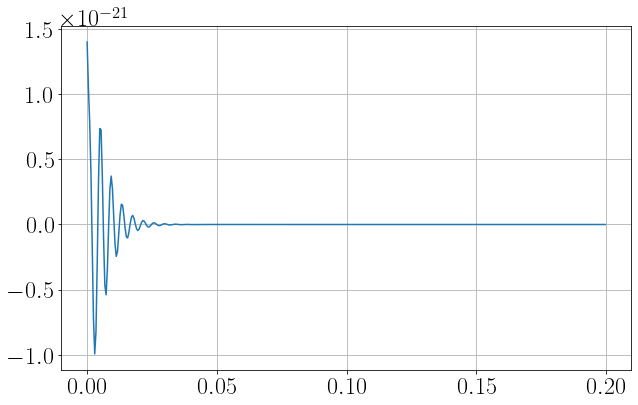

In [6]:
plt.plot(hpycbc.sample_times,hpycbc)

# Plot waveform and PSD in frequency domain

In [7]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = rd.Data(h, index=t0 + dt*np.arange(len(h)), ifo=dname)
        
        return raw_strain

# Plot posterior of A221 for srate = 2048 and 4096

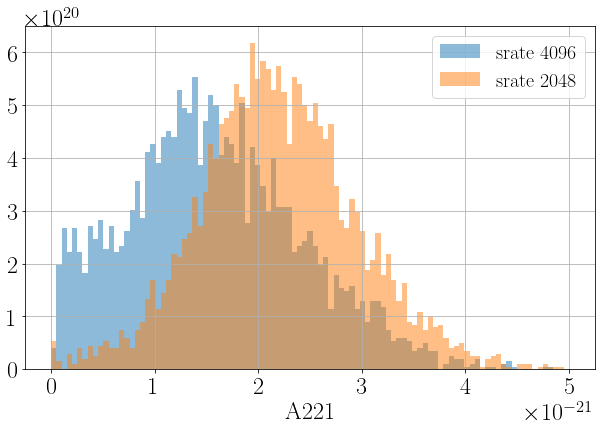

In [10]:
fit4096 = rd.Fit(model='mchi_aligned')
fit2048 = rd.Fit(model='mchi_aligned')

fit4096.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0602_srate4096.nc')
fit2048.result = az.from_netcdf('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0603_srate2048_pystan.nc')

A4096 = fit4096.result.posterior.A.stack(samples=('chain','draw'))
A2048 = fit2048.result.posterior.A.stack(samples=('chain','draw'))

bins = np.linspace(0,5e-21,100)
plt.hist(A4096[1].values,alpha=0.5,bins=bins,density=True,label='srate 4096')
plt.hist(A2048[1].values,alpha=0.5,bins=bins,density=True,label='srate 2048')
plt.legend()
plt.xlabel('A221')
plt.savefig('/work/yifan.wang/WWW/GWevents/figure/A221pos.png',bbox_inches='tight')

In [11]:
p = A4096[1].values
np.median(p)/np.std(p)

1.8051892520833734

In [52]:
mf = fit4096.result.posterior.M.stack(samples=('chain','draw'))
af = fit4096.result.posterior.chi.stack(samles=('chain','draw'))
mfmax = mf.values[imaxlp]
afmax = af.values[imaxlp]
mfmax,afmax

(82.04584602455077, 0.8811227488608455)

In [53]:
print('For srate 4096 Hz, mode 220 f and tau are: ',rd.qnms.get_ftau(mfmax, afmax, 0, l=2, m=2))

For srate 4096 Hz, mode 220 f and tau are:  (256.4451741637538, 0.005968168269336123)


In [55]:
print('For srate 4096 Hz, mode 221 f and tau are: ',rd.qnms.get_ftau(mfmax, afmax, 1, l=2, m=2))

For srate 4096 Hz, mode 221 f and tau are:  (254.5565810641483, 0.0019818180384027387)


In [56]:
mf = fit2048.result.posterior.M.stack(samples=('chain','draw'))
af = fit2048.result.posterior.chi.stack(samles=('chain','draw'))
mfmax = mf.values[imaxlp]
afmax = af.values[imaxlp]
mfmax,afmax

(76.44821752123468, 0.7821620400355006)

In [59]:
print('For srate 2048 Hz, mode 220 f and tau are: ',rd.qnms.get_ftau(mfmax, afmax, 0, l=2, m=2))

For srate 2048 Hz, mode 220 f and tau are:  (242.996818266059, 0.004902710793961671)


In [60]:
print('For srate 2048 Hz, mode 221 f and tau are: ',rd.qnms.get_ftau(mfmax, afmax, 1, l=2, m=2))

For srate 2048 Hz, mode 221 f and tau are:  (239.30070353386856, 0.0016246334842544377)


# Plot the $2\times |h(f)| \times \sqrt{f}$

In [61]:
def plot_snr_eachbin(path='/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0602_srate4096.nc',
               srate=4096):
    
    fit = rd.Fit(model='mchi_aligned')
    fit.result = az.from_netcdf(path)
    
    #Read in strain data
    ifos = ['H1', 'L1']
    input_path = '/work/yifan.wang/ringdown/GW150914/maxisi-data-release/{i}-{i}1_GWOSC_16KHZ_R1-1126257415-4096.hdf5'
    raw_strain = {i: read_strain(input_path.format(i=i[0]), i) for i in ifos}
    for s in raw_strain.values():
        fit.add_data(s)
    T = 0.2
    fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)
    # condition data
    fit.condition_data(ds=int(round(raw_strain[ifos[0]].fsamp/srate)), flow=20)
    fit.compute_acfs()
    
    #read in maxL waveform template
    hs = fit.result.posterior.h_det.stack(samples=('chain', 'draw'))
    lp = fit.result.sample_stats.lp.stack(samples=('chain','draw'))
    imaxlp = np.argmax(lp.values)
    for ifo in ['H1','L1']:
        if ifo == 'H1':
            hsmax = hs.values[0,:,imaxlp]
            psd = fit.data['H1'].get_psd()
        elif ifo == 'L1':
            hxmas = hs.values[1,:,imaxlp]
            psd = fit.data['L1'].get_psd()
        #save the waveform into a PyCBC TimeSeries type
        h = TimeSeries(hsmax,delta_t=1/srate)
        hfreq = h.to_frequencyseries()
        #plot figures for H1 and L1 separately
        plt.figure()
        
        #psdinterp = interp1d(psd.index.values,psd.values)
        f = hfreq.sample_frequencies
        #df = f[1]-f[0]
        snr_integrand = 2 * abs(hfreq.data) * f**0.5
        plt.plot(f,snr_integrand,label=str(ifo)+' $2|h(f)|\sqrt{f}$ (maxL waveform)')
        plt.plot(psd.index.values[1:],np.sqrt(psd.values[1:]),label=str(ifo)+' ASD')
        plt.xscale('log')
        plt.yscale('log')
        plt.legend()
        #optimal_snr = np.sqrt(2*np.sum(snr_integrand))
        plt.title('sample rate '+str(srate)+' '+str(ifo))
        plt.savefig(str(ifo)+'_srate'+str(srate)+'.png',bbox_inches='tight')
        
        #save txt
        np.savetxt(str(ifo)+'_'+'srate'+str(srate)+'_whitenh.txt',np.transpose([f,snr_integrand]))
        np.savetxt(str(ifo)+'_'+'srate'+str(srate)+'_asd.txt',np.transpose([psd.index.values,np.sqrt(psd.values)]))

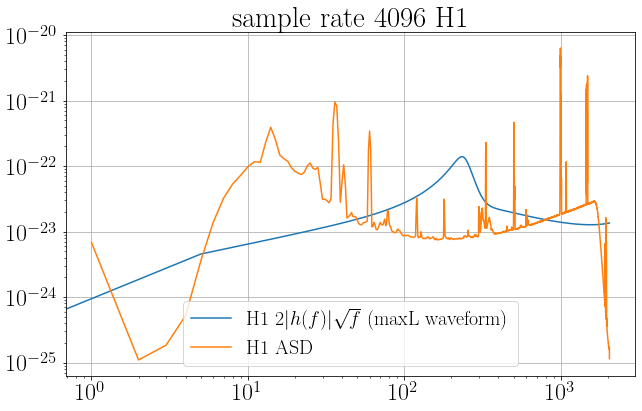

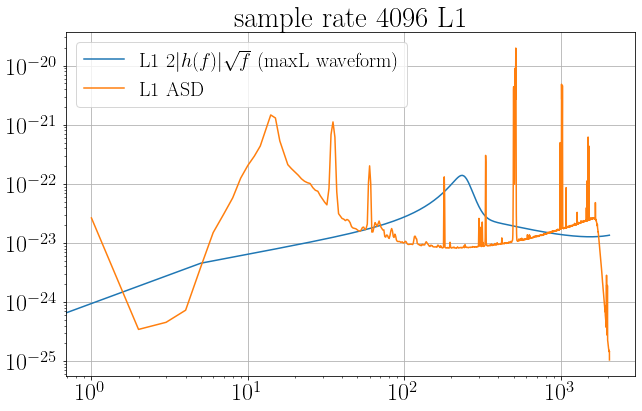

In [62]:
plot_snr_eachbin(path='/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0602_srate4096.nc',
               srate=4096)

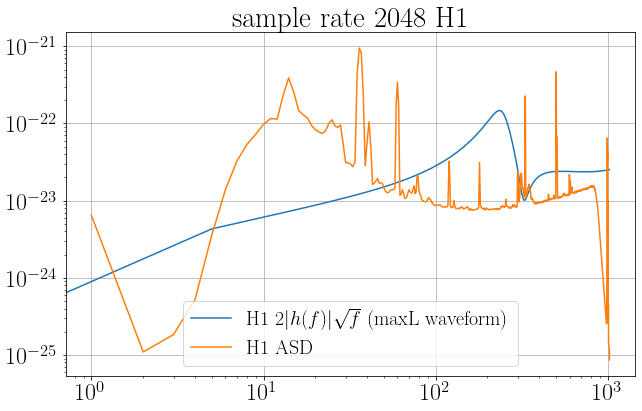

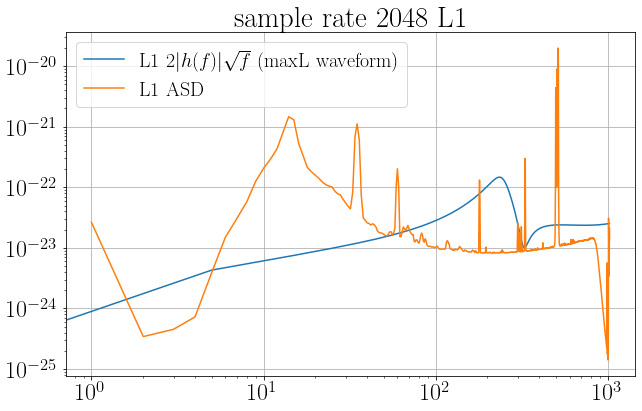

In [63]:
plot_snr_eachbin('/work/yifan.wang/ringdown/GW150914/maxisi-data-release/my_gw150914_0603_srate2048_pystan.nc',2048)

In [64]:
h1_4096_asd = np.loadtxt('./H1_srate4096_asd.txt')
h1_4096_wh = np.loadtxt('./H1_srate4096_whitenh.txt')
h1_2048_asd = np.loadtxt('./H1_srate2048_asd.txt')
h1_2048_wh = np.loadtxt('./H1_srate2048_whitenh.txt')

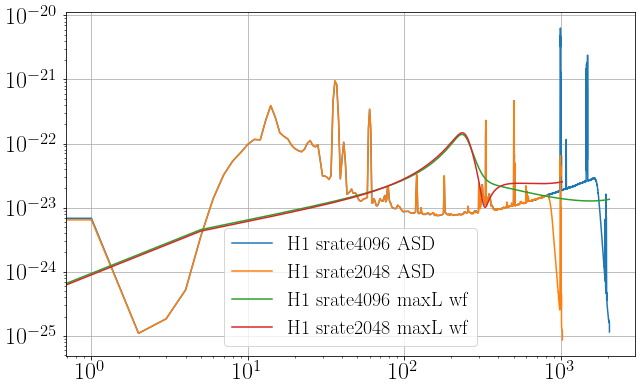

In [67]:
plt.plot(h1_4096_asd[:,0],h1_4096_asd[:,1],label='H1 srate4096 ASD')
plt.plot(h1_2048_asd[:,0],h1_2048_asd[:,1],label='H1 srate2048 ASD')
plt.plot(h1_4096_wh[:,0],h1_4096_wh[:,1],label='H1 srate4096 maxL wf')
plt.plot(h1_2048_wh[:,0],h1_2048_wh[:,1],label='H1 srate2048 maxL wf')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('/work/yifan.wang/WWW/GWevents/figure/H1_compared2048_4096.png',bbox_inches='tight')